In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
assessments = pd.read_csv('assessments.csv')

* code_module — идентификационный код предмета.
* code_presentation — семестр (Идентификационный код).
* id_assessment — тест (Идентификационный номер ассессмента).
* assessment_type — тип теста. Существуют три типа оценивания: оценка преподавателя (TMA), компьютерная оценка (СМА), экзамен по курсу (Exam).
* date — информация об окончательной дате сдачи теста. Рассчитывается как количество дней с момента начала семестра. Дата начала *семестра имеет номер 0 (ноль).
* weight — вес теста в % в оценке за курс. Обычно экзамены рассматриваются отдельно и имеют вес 100%; сумма всех остальных оценок составляет 100%.

In [3]:
courses = pd.read_csv('courses.csv')

* code_module — предмет (идентификационный код).
* code_presentation — семестр (идентификационный код).
* module_presentation_length — продолжительность семестра в днях.

In [4]:
student_assessment = pd.read_csv('studentAssessment.csv')

* id_assessment — тест (идентификационный номер).
* id_student — идентификационный номер студента.
* date_submitted — дата сдачи теста студентом, измеряемая как количество дней с начала семестра.
* is_banked — факт перезачета теста с прошлого семестра (иногда курсы перезачитывают студентам, вернувшимся из академического отпуска).
* score — оценка учащегося в этом тесте. Диапазон составляет от 0 до 100. Оценка ниже 40 неудачная/неуспешная сдача теста.

In [5]:
student_reg = pd.read_csv('studentRegistration.csv')

* code_module — предмет (идентификационный код).
* code_presentation — семестр (идентификационный код)
* id_student — идентификационный номер студента.
* date_registration — дата регистрации студента. Это количество дней, измеренное от начала семестра (например, отрицательное значение -30 означает, что студент зарегистрировался на прохождение курса за 30 дней до его начала).
* date_unregistration — дата отмены регистрации студента с предмета. У студентов, окончивших курс, это поле остается пустым.

#### Сколько студентов успешно сдали только один предмет? (Успешная сдача — это зачёт по предмету на экзамене) 

In [6]:
# объединим информацию об оценках студентов с информацией о типе теста
full_assessments = assessments.merge(student_assessment, how = 'inner', on = 'id_assessment')
full_assessments

,code_module,code_presentation,id_assessment,assessment_type,date,weight,id_student,date_submitted,is_banked,score
0,AAA,2013J,1752,TMA,19.0,10.0,11391,18,0,78.0
1,AAA,2013J,1752,TMA,19.0,10.0,28400,22,0,70.0
2,AAA,2013J,1752,TMA,19.0,10.0,31604,17,0,72.0
3,AAA,2013J,1752,TMA,19.0,10.0,32885,26,0,69.0
4,AAA,2013J,1752,TMA,19.0,10.0,38053,19,0,79.0
...,...,...,...,...,...,...,...,...,...,...
173907,GGG,2014J,37437,TMA,173.0,0.0,652462,172,0,60.0
173908,GGG,2014J,37437,TMA,173.0,0.0,652539,176,0,75.0
173909,GGG,2014J,37437,TMA,173.0,0.0,653157,187,0,70.0
173910,GGG,2014J,37437,TMA,173.0,0.0,653252,171,0,70.0


In [7]:
full_assessments.query('score > 39 and assessment_type == "Exam"').groupby('id_student', as_index=False)\
                                      .agg({'id_assessment':'count'})\
                                      .rename(columns = {'id_assessment':'succeeded_number'})\
                                      .query('succeeded_number == 1')[['id_student']]\
                                      .count()

id_student    3802
dtype: int64

##### Самый сложный и самый простой экзамен: найдем курсы и экзамены в рамках курса, которые обладают самой низкой и самой высокой завершаемостью
complete_rate = завершаемость = кол-во успешных экзаменов / кол-во всех попыток сдать экзамен

In [8]:
#Успешной сдачей считается оценка выше 40 баллов по предмету, поэтому берем объединенный датафрейм
full_exams = full_assessments.query("assessment_type =='Exam'")\
                                .groupby(['id_assessment', 'assessment_type'], as_index=False)\
                                .agg({'id_student':'count'})\
                                .rename(columns={'id_student':'exams_number'})

In [9]:
passed_exams = full_assessments.query("assessment_type =='Exam' and score >= 40")\
            .groupby(['id_assessment', 'assessment_type'], as_index=False)\
            .agg({'id_student':'count'})\
            .rename(columns={'id_student':'passed_exams_number'})

In [10]:
exams = passed_exams.merge(full_exams[['id_assessment', 'exams_number']], on='id_assessment')

In [11]:
exams['complete_rate'] = round(exams.passed_exams_number / exams.exams_number*100, 1)


In [12]:
exams.sort_values('complete_rate', ascending = False)

,id_assessment,assessment_type,passed_exams_number,exams_number,complete_rate
4,25361,Exam,485,524,92.6
3,25354,Exam,878,968,90.7
0,24290,Exam,664,747,88.9
5,25368,Exam,842,950,88.6
1,24299,Exam,1019,1168,87.2
2,25340,Exam,504,602,83.7


Самым легкий ассессмент 25361
Самый сложный ассессмент 25340

##### Определим средний срок сдачи экзаменов по каждому предмету

сдача экзамена - это успешное его прохождение студентом
есть студенты, которым перезачли тесты с прошлого семестра, у таких студентов дата сдачи отрицательная, поэтому нужно их отфильтровать

In [13]:
full_assessments.query("is_banked == 1")

,code_module,code_presentation,id_assessment,assessment_type,date,weight,id_student,date_submitted,is_banked,score
1641,AAA,2014J,1758,TMA,19.0,10.0,603861,-1,1,61.0
1685,AAA,2014J,1758,TMA,19.0,10.0,1970390,-1,1,78.0
1690,AAA,2014J,1758,TMA,19.0,10.0,2073016,-1,1,60.0
1693,AAA,2014J,1758,TMA,19.0,10.0,2139353,-1,1,65.0
1708,AAA,2014J,1758,TMA,19.0,10.0,2358969,-1,1,68.0
...,...,...,...,...,...,...,...,...,...,...
172348,GGG,2014J,37435,TMA,61.0,0.0,631446,-1,1,72.0
172991,GGG,2014J,37436,TMA,124.0,0.0,624767,-1,1,90.0
173002,GGG,2014J,37436,TMA,124.0,0.0,631446,-1,1,70.0
173744,GGG,2014J,37437,TMA,173.0,0.0,624767,-1,1,75.0


In [14]:
full_assessments.query("assessment_type =='Exam' and is_banked != 1")\
                .groupby(['code_module'])\
                .agg({'date_submitted':'mean'}).round(1)\
                .rename(columns={'date_submitted':'avg_date'})

,avg_date
code_module,
CCC,239.4
DDD,237.9


#### Посмотрим самые популярные курсы (ТОП-3) по количеству регистраций на них. А также курсы с самым большим оттоком (ТОП-3)

In [15]:
student_reg.isna().sum()

code_module                0
code_presentation          0
id_student                 0
date_registration         45
date_unregistration    22521
dtype: int64

In [16]:
#ТОП-3 самых популярных курсов
student_reg.query('date_registration != "NaN"').groupby('code_module', as_index = False)\
           .agg({'id_student':'nunique'}).rename(columns={'id_student':'reg_number'})\
           .sort_values('reg_number', ascending=False).head(3)

,code_module,reg_number
1,BBB,7692
5,FFF,7397
3,DDD,5848


In [17]:
#ТОП-3 курсов с самым большим оттоком
student_reg.query('date_unregistration.notna()', engine = 'python')\
           .groupby('code_module',as_index = False)\
           .agg({'id_student':'nunique'}).rename(columns={'id_student':'unreg_number'})\
           .sort_values('unreg_number', ascending=False).head(3)

,code_module,unreg_number
1,BBB,2314
5,FFF,2249
3,DDD,2065


#### Проведем когортный (семестровый) анализ
В период с начала 2013 по конец 2014 найдем семестр с самой низкой завершаемостью курсов и самыми долгими средними сроками сдачи курсов.

In [27]:
full_exams = full_assessments.query("assessment_type =='Exam' and is_banked != 1").groupby('code_presentation', as_index=False)\
                                            .agg({'id_student':'count'})\
                                            .rename(columns={'id_student':'exams_number'})

In [28]:
passed_exams = full_assessments.query("assessment_type =='Exam' and score >= 40 and is_banked != 1")\
            .groupby('code_presentation', as_index=False)\
            .agg({'id_student':'count'})\
            .rename(columns={'id_student':'passed_exams_number'})

In [29]:
exams = passed_exams.merge(full_exams[['code_presentation', 'exams_number']], on='code_presentation')
exams['complete_rate'] = round(exams.passed_exams_number / exams.exams_number*100, 1)

In [35]:
exams

,code_presentation,passed_exams_number,exams_number,complete_rate
0,2013B,504,602,83.7
1,2013J,878,968,90.7
2,2014B,1149,1271,90.4
3,2014J,1861,2118,87.9


In [37]:
expiration = full_assessments.query("assessment_type =='Exam'")\
                             .groupby('code_presentation', as_index=False)\
                             .agg({'date_submitted':'mean'}).round(1)\
                             .rename(columns={'date_submitted':'avg_date'})

In [38]:
cohort = expiration.merge(exams[['code_presentation', 'complete_rate']], on='code_presentation')
cohort

,code_presentation,avg_date,complete_rate
0,2013B,230.2,83.7
1,2013J,239.5,90.7
2,2014B,233.0,90.4
3,2014J,243.7,87.9


In [40]:
print(f'''Семестр с самой низкой завершаемостью курсов
{cohort.loc[cohort['complete_rate'] == cohort.complete_rate.min(), 'code_presentation'].iloc[0]}''')
print(f'''Семестр с самым долгим средним сроком сдачи курсов 
{cohort.loc[expiration['avg_date'] == cohort.avg_date.max(), 'code_presentation'].iloc[0]}''')

Семестр с самой низкой завершаемостью курсов
2013B
Семестр с самым долгим средним сроком сдачи курсов 
2014J


#### Проведем RFM-кластеризацию аудитории нашей онлайн-школы

Выбранные метрики: R - среднее время сдачи одного теста, F - завершаемость курсов, M - среднее количество баллов, получаемое за экзамен. 

In [23]:
#Для анализа необходимо подготовить данные. Возьмем датафрейм, сгруппируем по id студентов, вычислим необходимые параметры.

In [67]:
RFM = full_assessments.query("date_submitted > 0")\
                      .groupby('id_student', as_index=False)\
                      .agg({'date_submitted':'mean','score':'mean'}).round(1)\
                      .rename(columns={'date_submitted':'recency','score':'monetary' })

In [68]:
full_exams_1 = full_assessments.query("date_submitted > 0")\
                               .groupby('id_student', as_index=False)\
                               .agg({'id_assessment':'count'})\
                               .rename(columns={'id_assessment':'exams_number'})

passed_exams_1 = full_assessments.query("score >= 40 and date_submitted > 0")\
                                 .groupby('id_student', as_index=False)\
                                 .agg({'id_assessment':'count'})\
                                 .rename(columns={'id_assessment':'passed_exams_number'})

exams_1 = passed_exams_1.merge(full_exams_1[['id_student', 'exams_number']], on='id_student')

exams_1['frequency'] = round(exams_1.passed_exams_number / exams_1.exams_number*100, 1)

RFM = RFM.merge(exams_1[['id_student', 'frequency']], on='id_student')
RFM = RFM.reindex(columns = ['id_student', 'recency', 'frequency', 'monetary'])

In [69]:
RFM.describe()

,id_student,recency,frequency,monetary
count,2.290600e+04,22906.000000,22906.000000,22906.000000
mean,7.096329e+05,102.452746,95.156693,74.026107
std,5.556911e+05,40.299211,12.032418,13.855629
min,6.516000e+03,1.000000,9.100000,10.600000
25%,5.053828e+05,79.700000,100.000000,65.800000
50%,5.896275e+05,111.200000,100.000000,76.300000
75%,6.450282e+05,126.200000,100.000000,84.475000
max,2.698588e+06,333.500000,100.000000,100.000000


Т.к. Среднее время сдачи одного теста имеет большой диапазон значений,при этом разница между 1-м, 2-м и 3-м квартилями
не такая большая, как между 3-м квартилем и максимальным значением, предложено 4 сегмента:
1 - короткие (0-80 дн), 2 -  средние (81-157 дн), 3 - длинные (158-234 дн),4 - очень длинные (более 235дн) 

Т.к. завершаемость курсов в целом высокая, то предложено два сегмента:
1- низкая завершаемость, 2 - высокая завершаемость

Т.к. система оценки стобалльная, при этом успехом считается оценка более 40, предложено 4 сегмента:
1 - неуд (0-40 баллов), 2 - удовл (41-65 баллов), 3 - хорошо (66-75 баллов), 4 - отлично (76-100 баллов)

In [79]:
RFM['R'] = pd.cut(RFM.recency, bins=[0, 80, 157, 234, 261], labels = ['1', '2', '3', '4'])

In [80]:
RFM['F'] = pd.cut(RFM.frequency, bins=2, labels = ['1', '2'])

In [81]:
RFM['M'] = pd.cut(RFM.monetary, bins=[0, 40, 65, 75, 100], labels = ['1', '2', '3', '4'])

In [83]:
RFM['RFM_score'] = RFM.R.astype(str) + RFM.F.astype(str) + RFM.M.astype(str)

In [84]:
RFM

,id_student,recency,frequency,monetary,R,F,M,RFM_score
0,6516,111.6,100.0,61.8,2,2,2,222
1,8462,55.0,100.0,87.7,1,2,4,124
2,11391,112.4,100.0,82.0,2,2,4,224
3,23629,55.8,100.0,82.5,1,2,4,124
4,23698,133.4,100.0,74.4,2,2,3,223
...,...,...,...,...,...,...,...,...
22901,2698251,121.4,85.7,58.1,2,2,2,222
22902,2698257,116.2,100.0,67.8,2,2,3,223
22903,2698535,90.4,50.0,39.2,2,1,1,211
22904,2698577,106.2,100.0,64.4,2,2,2,222


<AxesSubplot:xlabel='RFM_score'>

<Figure size 2160x720 with 0 Axes>

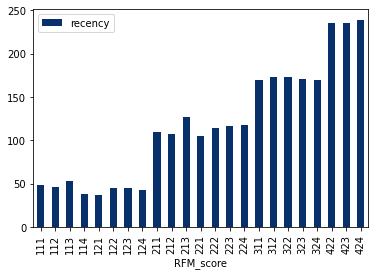

In [85]:
plt.figure(figsize = (30,10))
RFM.groupby('RFM_score').agg({'recency':'mean'}).plot(kind='bar', colormap='Blues_r')

#### Выводы:

В целом результаты RFM анализа используются для удержания клиентов, повышения доходов компании, повышения лояльности клиентов.
Результаты RFM анализа применительно к онлайн-школе можно использовать для рекламы и предложения дополнительных продуктов школы.  
<br/>
Например, студентам с низким средним баллом и низкой завершаемостью по предмету можно предложить доп. обучение (курс) по этим
предметам (сегменты 211, 212, 213, 311, 312, 313) или персональное занятие с преподавателем (мастер-класс).  
<br/>
Так же студентам с большим сроком сдачи ассессментов можно предложить изменить формат обучения (групповой/индивидуальный). Для тех, кто совсем затянул обучение (сегменты 422, 423, 424 которых большинство, как показывает график) можно предложить перейти на клубную систему оплаты, чтобы они могли учиться в комфортные для себя сроки, что повысит доход компании.  
<br/>
Студентам сегментов 111, 112, 113 для повышения успеваемости можно предложить доп. курсы по темам, по которым у них низкий средний балл.  
<br/>
Успешным студентам сегментов 123, 124, 223, 224 необходимо высылать рекламу с другими курсами школы и предлагать скидки на продолжение обучения (повышение грейда).